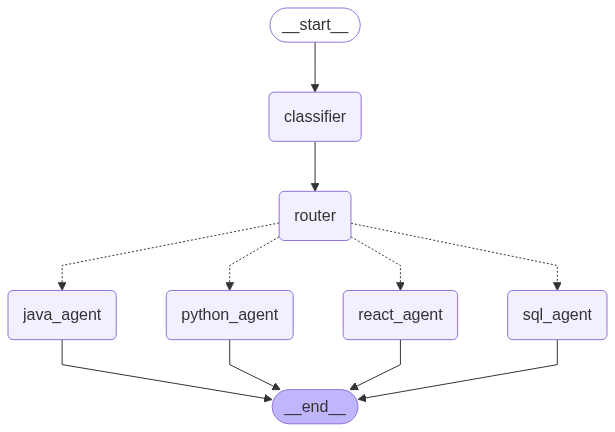

In [3]:

from typing import Annotated, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langchain_ollama import ChatOllama
import getpass
import os
from langgraph.checkpoint.memory import MemorySaver
import json
import re
from IPython.display import Image, display


llm = ChatOllama(model="gemma3:1b")


class MessageClassifier(BaseModel):
   message_type: Literal["React", "Java", "Python", "SQL"] = Field(
      ...,
      description="Classify if the message requires support from a React, Java, Python, or SQL expert"
   )


class State(TypedDict):
    messages: Annotated[list,add_messages]
    message_type: str | None

def classify_message(state:State):
   last_message = state["messages"][-1]
   classifier_llm  = llm.with_structured_output(MessageClassifier)
   
   result= classifier_llm.invoke([
      {
         "role":"system",
         "content":"""Classify the user message as either:
            - 'React': if it requires help with React development
            - 'Java': if it requires help with Java development
            - 'Python': if it requires help with Python development
            - 'SQL': if it requires help with SQL development
            """
        },
        {
           "role":"user",
           "content":last_message.content
        }
   ])
   return {"message_type": result.message_type}

def router(state:State):
   message_type = state.get("message_type","React")
   
   if message_type == "React":
      return {"next":"react_agent"}
   elif message_type == "Java":
      return {"next":"java_agent"}
   elif message_type == "Python":
      return {"next":"python_agent"}
   elif message_type == "SQL":
      return {"next":"sql_agent"}
   else:
      return {"next":"react_agent"}

def react_agent(state:State):
   last_message = state["messages"][-1]
   messages = [
      {
         "role": "system",
         "content": """You are a React expert helping to triage and document frontend issues for the React development team.
         For each ticket, provide the following:
         1. summary: Brief overview of the issue
         2. technical_analysis: Initial assessment of what might be causing the problem
         3. priority: High/Medium/Low based on impact
         4. suggested_approach: Key steps the React team should take
         5. additional_notes: Any relevant context about React version, dependencies, or browser compatibility
         
         Format your response using these headers for clarity.
         Don't include any other text in your response.
         Don't add any follow up questions.
         respond only with valid JSON using the fields: summary, technical_analysis, priority, suggested_approach, additional_notes. Do not include Markdown formatting or backticks. Don not change the keys.
         """
      },
      {
         "role": "user",
         "content": last_message.content
      }
   ]
   response = llm.invoke(messages)
   return {"messages": [{"role": "assistant", "content": response.content}]}

def java_agent(state:State):
   last_message = state["messages"][-1]
   messages = [
      {
         "role": "system",
         "content": """You are a Java expert helping to triage and document backend issues for the Java development team.
         For each ticket, provide the following:
         1. summary: Brief overview of the issue
         2. technical_analysis: Initial assessment of what might be causing the problem
         3. priority: High/Medium/Low based on impact
         4. suggested_approach: Key steps the Java team should take
         5. additional_notes: Any relevant context about Java version, frameworks, or performance implications
         
         Format your response using these headers for clarity.
         Don't include any other text in your response.
         Don't add any follow up questions.
         respond only with valid JSON using the fields: summary, technical_analysis, priority, suggested_approach, additional_notes. Do not include Markdown formatting or backticks. Don not change the keys.
         """
      },
      {
         "role": "user",
         "content": last_message.content
      }
   ]
   response = llm.invoke(messages)
   return {"messages": [{"role": "assistant", "content": response.content}]}

def python_agent(state:State):
   last_message = state["messages"][-1]
   messages = [
      {
         "role": "system",
         "content": """You are a Python expert helping to triage and document Python-related issues for the Python development team.
         For each ticket, provide the following:
         1. summary: Brief overview of the issue
         2. technical_analysis: Initial assessment of what might be causing the problem
         3. priority: High/Medium/Low based on impact
         4. suggested_approach: Key steps the Python team should take
         5. additional_notes: Any relevant context about Python version, dependencies, or environment setup
         
         Format your response using these headers for clarity.
         Don't include any other text in your response.
         Don't add any follow up questions.
         respond only with valid JSON using the fields: summary, technical_analysis, priority, suggested_approach, additional_notes. Do not include Markdown formatting or backticks. Don not change the keys.
         """
      },
      {
         "role": "user",
         "content": last_message.content
      }
   ]
   response = llm.invoke(messages)
   return {"messages": [{"role": "assistant", "content": response.content}]}

def sql_agent(state:State):
   last_message = state["messages"][-1]
   messages = [
      {
         "role": "system",
         "content": """You are a SQL expert helping to triage and document database issues for the SQL development team.
         For each ticket, provide the following:
         1. summary: Brief overview of the issue
         2. technical_analysis: Initial assessment of what might be causing the problem
         3. priority: High/Medium/Low based on impact
         4. suggested_approach: Key steps the SQL team should take
         5. additional_notes: Any relevant context about database type, schema implications, or performance considerations
         
         Format your response using these headers for clarity.
         Don't include any other text in your response.
         Don't add any follow up questions.
         respond only with valid JSON using the fields: summary, technical_analysis, priority, suggested_approach, additional_notes. Do not include Markdown formatting or backticks. Don not change the keys.
         """
      },
      {
         "role": "user",
         "content": last_message.content
      }
   ]
   response = llm.invoke(messages)
   return {"messages": [{"role": "assistant", "content": response.content}]}

def run_chatbot(user_input):
   graph_builder = StateGraph(State)
   graph_builder.add_node("classifier",classify_message)
   graph_builder.add_node("router",router)
   graph_builder.add_node("react_agent",react_agent)
   graph_builder.add_node("java_agent",java_agent)
   graph_builder.add_node("python_agent",python_agent)
   graph_builder.add_node("sql_agent",sql_agent)

   graph_builder.add_edge(START,"classifier")
   graph_builder.add_edge("classifier","router")
   graph_builder.add_conditional_edges(
      "router",
      lambda state: state.get("next"),
      {
         "react_agent":"react_agent",
         "java_agent":"java_agent",
         "python_agent":"python_agent",
         "sql_agent":"sql_agent"
      }
   )

   graph_builder.add_edge("react_agent",END)
   graph_builder.add_edge("java_agent",END)
   graph_builder.add_edge("python_agent",END)
   graph_builder.add_edge("sql_agent",END)

   graph = graph_builder.compile()
   display(Image(graph.get_graph().draw_mermaid_png()))

   

if __name__ == "__main__":
   run_chatbot("sjhdu")

